In [1]:
import scipy
from scipy.special import jn, jn_zeros
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from scipy.special import eval_legendre as legendre

from astropy.cosmology import Planck15
import astropy.units as u

from power_spectra import * 
from projected_corr_rsd import *
from wigner_functions import wigner_d
from wigner_functions import associated_legendre as aLegendre

import numpy as np
import pandas as pd

import matplotlib as mpl
from matplotlib import pyplot as plt

from scipy.stats import linregress as linreg

%matplotlib inline

In [2]:
from wigner_functions import associated_legendre

In [3]:
import warnings
warnings.filterwarnings('ignore')

## Reading Simulation Data

In [4]:
%pylab inline

ignore_keys=['rp','r','jk','cov','corr','jk_err','jkerr','data','data0']
class cov_corr():
    def mean_calc(self,data=[],axis=1):
        return np.mean(data,axis)

    def var_calc(self,data=[],axis=1):
        return np.var(data,axis)

    def residual_calc(self,data=[],axis=1): #calculate residual that go into cov calculation, y-E(y)
        mean=self.mean_calc(data,axis)
        dim0=len(mean)
        dim1=np.shape(data)[axis]
        #print dim0,dim1,axis
# since mean is always 1-d array, [mean]*dim1 always give matrix [dim0 X dim1]...
#hence depending on dimension of data may need to transpose to get correct residuals
        try:
            res=data-np.transpose([mean]*dim1)
            print ("transpose")
        except:
            res=data-[mean]*dim1
        return res

    def cov_matrix2(self,data=[],axis=1,ddof=0):
        return np.cov(data,rowvar=axis)

    def cov_matrix(self,data=[],axis=1,ddof=0):
        #return np.cov(data,rowvar=axis,ddof=1) #ddof=0 for correct variance
        mean=self.mean_calc(data,axis)
        dim0=len(mean)
        dim1=np.shape(data)[axis]
        res=self.residual_calc(data=data,axis=axis)
        cov=np.zeros((dim0,dim0))
        if len(res[0])!=dim1:
            res=np.transpose(res)#residual has dimension of data..
                                #depending on axis value, may need to transpose for correct covariance
        for i in np.arange(dim0):
            for j in np.arange(dim0):
                cov[i][j]+=np.sum(res[i]*res[j])
        cov/=np.float64(dim1-ddof)
        return cov

    def cross_cov_matrix2(self,data1=[],data2=[],axis=1,ddof=0):
        cross_cov=np.cov(data1,data2,rowvar=axis)
        N1=len(data1[0])
        N2=len(data2[0])
        cov2=np.zeros((N1,N2))
        for i in np.arange(N1):
            for j in np.arange(N2):
                cov2[i][j]=cross_cov[i+N1][j]
        return cov2

    def cross_cov_matrix(self,data1=[],data2=[],axis=1,ddof=0):
    #return np.cov(data,rowvar=axis,ddof=1) #ddof=0 for correct variance
        mean1=self.mean_calc(data1,axis)
        mean2=self.mean_calc(data2,axis)
        dim0=len(mean1)
        dim2=len(mean2)
        dim1=np.shape(data1)[axis]
        res1=self.residual_calc(data=data1,axis=axis)
        res2=self.residual_calc(data=data2,axis=axis)
        cov=np.zeros((dim0,dim2))
        if dim0!=dim2:
            print ('cross cov: dimensions of data 1 and data2 not equal')
        if len(res1[0])!=dim1:
            res2=np.transpose(res2)
            res1=np.transpose(res1)#residual has dimension of data..
                            #depending on axis value, may need to transpose for correct covariance
        for i in np.arange(dim0):
            for j in np.arange(dim2):
                cov[i][j]+=np.sum(res1[i]*res2[j])
        cov/=np.float64(dim1-ddof)
        return cov

    #for some reason numpy covariance matrix has some constant multiplied to it..
    #seems to be some func of N but can't figure it out.
    #this func returns that constants value by comparing it with variance
    def var_cov_comparison(self,var=[],cov=[]):
        l=len(cov[0])
        v2=np.zeros_like(var)
        for i in np.arange(l):
            v2[i]=cov[i][i]
        r=var/v2
        x=r==r[0]
        if sum(x)<l:
            print ("variance-covariance miss match") #return full ratio array in case r is not constant
            return r  #note comparison can be easily fooled due to floating point error
        return [r[0]]

    def corr_matrix(self,cov_mat=[]): #correlation matrix
        diag=np.diag(cov_mat)
        return cov_mat/np.sqrt(np.outer(diag,diag))
        # dim=len(cov_mat[0])
        # var=np.zeros(dim)
        # corr=np.zeros((dim,dim))
        # for i in np.arange(dim):
        #     var[i]=cov_mat[i][i]
        # for i in np.arange(dim):
        #     for j in np.arange(dim):
        #         corr[i][j]=cov_mat[i][j]/np.sqrt(var[i]*var[j])
        # return corr

    def cross_corr_matrix(self,cov_mat=[],data1=[],data2=[],axis=1): #correlation matrix
        dim=len(cov_mat[0])
        var1=self.var_calc(data1,axis)
        var2=self.var_calc(data2,axis)
        corr=np.zeros((dim,dim))
#        for i in np.arange(dim):
 #           var[i]=cov_mat[i][i]
        for i in np.arange(dim):
            for j in np.arange(dim):
                corr[i][j]=cov_mat[i][j]/np.sqrt(var1[i]*var2[j])
        return corr

    #stack column from various dictionary elements to get a data matrix which goes into covariance calculations
    #incase dict elements have several columns, var defines the column to be used. better to have named columns
    def dict_stack(self,dic={},var='',ignore_keys=ignore_keys):
        keys=dic.keys()
        j=0
        mat=[]
        axis=0
        for i in keys:
            if i in ignore_keys:
                #print 'cov_corr.dict_stack::',i,'ignored in stacking'
                continue
            if j==0:
                if not check_empty(var):
                    mat=dic[i][var]
                else:
                    mat=dic[i]#[:]
                j=j+1
                continue
            if not check_empty(var):
                mat=np.vstack((mat,dic[i][var]))
            else:
                mat=np.vstack((mat,dic[i]))#dic[i][:]
                
        #print(mat)
        return mat,axis


    def dict_cov(self,dic={},var='',stack=0,axis=0,ddof=0,ignore_keys=ignore_keys):
        if stack!=0:
            #print "cov_corr: Stacking dictionary"
            mat,axis=self.dict_stack(dic=dic,var=var,ignore_keys=ignore_keys)
            #print "cov_corr: dictionary stacked"
        if stack==0:
            #print "no stacking:",var,axis
            mat=dic[var]
            axis=axis
        cov=self.cov_matrix2(data=mat,axis=axis,ddof=ddof)
        #print cov.shape
        corr=self.corr_matrix(cov)
        return cov,corr


    def dict_cross_cov(self,dic={},dic2={},var1='',var2='',stack=0,axis=0,ddof=0):
        if stack!=0:
            #print "cov_corr: Stacking dictionary"
            mat1,axis=self.dict_stack(dic=dic,var=var1)
            if dic2:
                mat2,axis=self.dict_stack(dic=dic2,var=var2)
            else:
                mat2,axis=self.dict_stack(dic=dic,var=var2)
        if stack==0:
            #print "no stacking:",var,axis
            mat1=dic[var1]
            if dic2:
                mat2=dic2[var2]
            else:
                mat2=dic[var2]
            axis=axis
        cov=self.cross_cov_matrix2(data1=mat1,data2=mat2,axis=axis,ddof=ddof)
        corr=self.cross_corr_matrix(cov_mat=cov,data1=mat1,data2=mat2,axis=axis)
        return cov,corr

    def matrix_diagonalize(self,m=[]):
        N1=len(m)
        N2=len(m[0])
        for i in np.arange(N1):
            for j in np.arange(N2):
                if i==j:
                    continue
                m[i][j]=0
        return m

    def mat_inv(self,m=[]):
        return np.linalg.inv(m)

    def matrix_cut(self,mat=[],x=[]):
        m=mat[x]
        N=sum(x)
        m2=np.zeros((N,N))
        j=0
        for i in m:
            m2[j]=i[x]
            j=j+1
        return m2

    def chi_sq(self,theory=[],data=[],x=None,cov=[]):
        if x:
            data=data[x]
            theory=theory[x]
            cov=self.matrix_cut(mat=cov,x=x)
        cov_inv=self.mat_inv(m=cov)
        #print data.shape,theory.shape,cov.shape,cov_inv.shape
        N=len(data)
        chi_sq=0
        for i in np.arange(N):
            for j in np.arange(N):
                chi_sq+=((data[i]-theory[i])*(data[j]-theory[j])*(cov_inv[i][j]))
        #chi_sq/=2.
        return chi_sq,N


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [5]:
def jk_read(dataset='',var=None,njk=100,auto_cross='_cross',bins='_bins',
            home='',corr='_final',skiprows=0,**kwargs):
    data_jk={}
    filename=dataset
    try:
        data_jk['data']=np.genfromtxt(home+filename+bins+auto_cross+'_jk_final.dat',
                                      names=True,skip_header=skiprows)
        #print(home+filename+bins+auto_cross+'_jk_final.dat')
    except:
        print ('file not found')
    try:
        data_jk['data0']=np.genfromtxt(home+filename+bins+auto_cross+corr+'.dat',
                                       names=True,skip_header=skiprows)
    except:
        print ('file not found',home+filename+bins+auto_cross+corr+'.dat')
    for i in np.arange(njk):
        data_jk[i]=np.genfromtxt(home+filename+bins+auto_cross+'_jk'+str(i)+corr+'.dat',names=True,
                                 skip_header=skiprows)
    cc=cov_corr()
    if var and njk>0:
        data_jk['cov']={}
        data_jk['corr']={}
        for v in var:
            cov,corr=cc.dict_cov(dic=data_jk,var=v,stack=1,ignore_keys=['data','data0','cov','corr'])
            cov*=njk-1.
            data_jk['cov'][v]=cov
            data_jk['corr'][v]=corr
    return data_jk


In [6]:
file_dir_cross = '/hildafs/home/amshakir/corr_pc/corr_pc/temp/ia_project/'
file_dir_auto = '/hildafs/home/amshakir/corr_pc/corr_pc/temp/ia_project/density_auto/'

def get_path(file_dir, rsd=False, coords=6):
    
    path = ''
    
    if rsd: path += 'rsd_'
    else: path += 'no_rsd_'
        
    if coords == 6: path += 'rp_pi'
    else: path += 'r_mu'
        
    return file_dir+path+'/corr_data_out/'

def get_name(rsd=False, coords=6):
    
    name = 'data_'
    
    if rsd: name += 'rsd_'
    else: name += 'no_rsd_'
        
    if coords == 6: name += 'rp_pi'
    else: name += 'r_mu'
        
    return name

get_path(file_dir_cross, rsd=False, coords=6), get_name(rsd=False, coords=6)

('/hildafs/home/amshakir/corr_pc/corr_pc/temp/ia_project/no_rsd_rp_pi/corr_data_out/',
 'data_no_rsd_rp_pi')

In [7]:
njk=49

In [8]:
def check_empty(arr): # True is empty
    try:
        #print not arr.any()
        try:
            return not arr.any()
        except:
            if arr.size!=0: #for rec array
                return False
            else:
                return True
    except:
        #print not bool(arr)
        return not bool(arr) #for other python types, including dictionary

In [9]:
def series2grid(series, shape):
    return series.to_numpy().reshape(shape)

In [10]:
def read_output(home, var=['wgg'], bins2D=False, rsd=False, coords=6):
    bins = '_bins2D' if bins2D else '_bins'
    name = get_name(rsd=rsd, coords=coords)
    # print(name)
    return jk_read(dataset=name, var=var,njk=njk, bins=bins, home=get_path(home, rsd=rsd, coords=coords))

In [11]:
def read_output_manual(file_path, file_name, var=['wgg, wgp'], bins2D=False):
    bins = '_bins2D' if bins2D else '_bins'
    return jk_read(dataset=file_name, var=var, njk=njk, bins=bins, home=file_path)

## Setup

In [12]:
def taper(k=[],pk=[],large_k_lower=10,large_k_upper=30,low_k_lower=1.e-4,low_k_upper=1.e-3):
    pk_out=np.copy(pk)
    x=k>large_k_lower
    pk_out[x]*=np.cos((k[x]-large_k_lower)/(large_k_upper-large_k_lower)*np.pi/2.)
    x=k>large_k_upper
    pk_out[x]=0
    x=k<low_k_upper
    pk_out[x]*=np.cos((k[x]-low_k_upper)/(low_k_upper-low_k_lower)*np.pi/2.)
    x=k<low_k_lower
    pk_out[x]=0
    return pk_out

In [13]:
def DZ_int(z=[0],cosmo=None,rtol=1.e-4,tol=1.e-5): #linear growth factor.. full integral.. eq 63 in Lahav and suto
        Ez_func=cosmo.efunc
        def intf(z):
            return (1.+z)/(cosmo.H(z=z).value**3)
        dz=np.zeros_like(z,dtype='float32')
        inf=np.inf
        j=0
        for i in z:
            dz[j]+=cosmo.H(i).value*scipy_int1d(intf,i,inf,epsrel=rtol,epsabs=tol)[0]
            j=j+1
        dz=dz*2.5*cosmo.Om0*cosmo.H0**2
        return dz/dz[0] #check for normalization

In [14]:
cosmo = Planck15.clone()
cosmo_h = Planck15.clone(H0=100)

In [15]:
#set parameters for power spectra computations.
kmax=1000
kmin=1e-3
k_smooth=1
nk=8000*4
rmin=.1
rmax=100
non_linear=1

In [16]:
cosmo_fid=dict({'h':cosmo.h,'Omb':cosmo.Ob0,'Omd':cosmo.Om0-cosmo.Ob0,'s8':0.817,'Om':cosmo.Om0,
                'As':2.12e-09,'mnu':cosmo.m_nu[-1].value,'Omk':cosmo.Ok0,'tau':0.06,'ns':0.965,'w':-1,'wa':0})
pk_params={'non_linear':non_linear,'kmax':kmax,'kmin':kmin,'nk':nk}

In [17]:
PS = Power_Spectra(cosmo_params=cosmo_fid, pk_params=pk_params)

In [18]:
z_mean=0

pk,kh =PS.camb_pk(z=[z_mean])
pk=taper(k=kh,pk=pk[0])

In [19]:
rp=np.linspace(1, 80, 2000)
pi=np.linspace(-80, 80, 2000)

In [20]:
C1_rhoC = 0.0134
Om = cosmo.Om0

Dz=DZ_int(z=np.append([0],z_mean),cosmo=cosmo)# Dz is normalized to 1 at lowest z. 
Dz=Dz[1]/Dz[0]

zeta = C1_rhoC * Om / Dz

In [21]:
pcr = Projected_Corr_RSD(rp=rp, pi=pi, pi_max=100, l=[0,2,4,6], k=kh,spins=[0,2])

In [22]:
def plot_corr(rp, pi, xi, cont_levels, func):
    
    rpG, piG = np.meshgrid(rp, pi)
    
    figure = plt.figure(figsize=(8, 6))
    
    xi_cont = figure.add_axes([0.1, 0.1, 0.65, 0.8])
    xi_cb = figure.add_axes([0.78, 0.1, 0.02, 0.8])
    
    xi_cont.set_title('$\\xi_{' +func+ '}$', fontsize=16)
    xi_cont.set_xlabel('$r_{p}$ (Mpc/h)', fontsize=12)
    xi_cont.set_ylabel('$\\Pi$ (Mpc/h)')
    
    # cm = xi_cont.contourf(rpG, piG, xi, levels=cont_levels, norm=mpl.colors.LogNorm(), cmap=mpl.cm.tab20c)
    cm = xi_cont.contourf(
        np.concatenate((np.fliplr(-rpG), rpG), axis=1), 
        np.concatenate((piG, piG), axis=1), 
        np.concatenate((np.fliplr(xi), xi), axis=1), 
        levels=cont_levels, norm=mpl.colors.LogNorm(), cmap=mpl.cm.tab20c)

    
    plt.colorbar(cm, cax=xi_cb, format='%.3e')
    
    xi_cont.grid()
    
    return xi_cont

In [23]:
# First, we set up the most general possible function to mask input data in r-mu
def cut_data(rG, muG, xiG, thresh=2):
    rpG = rG * np.sqrt(1-muG**2)
    mask = rpG >= thresh
    return xiG * mask

In [24]:
global_rsd = True
global_rp_cut = 2

In [25]:
f = 0

if global_rsd:
    f = cosmo.Om0**.55

## Grab data from corr_pc

In [26]:
wgp_sim = pd.DataFrame(
    read_output(file_dir_cross, var=['wgg', 'wgp'], rsd=global_rsd)['data'][['rp', 'wgg', 'wgg_err', 'wgp', 'wgp_err']])

wgg_sim=pd.DataFrame(
    read_output(file_dir_auto, var=['wgg'], rsd=global_rsd)['data'][['rp', 'wgg', 'wgg_err']])

wgp_cov = read_output(file_dir_cross, var=['wgg', 'wgp'], rsd=global_rsd)['cov']['wgp']

wgg_cov = read_output(file_dir_auto, var=['wgg'], rsd=global_rsd)['cov']['wgg']

## $ \xi_{gg} $ and $ w_{gg} $ Calculations

In [27]:
rp = np.linspace(2, 25, 500)
pi = np.linspace(-25, 25, 1000)

In [28]:
def wgg(rp_interp, bg):
    
    xigg = (bg**2) * pcr.xi_rp_pi(f, bg1=bg, pk=pk, l=[0,2,4], spin=0, rp=rp, pi=pi)
    dpi = np.gradient(pi)
    
    wgg_pts = dpi@xigg
    wgg_interp = interp1d(rp, wgg_pts)
    
    return wgg_interp(rp_interp)

0.8488539903945838

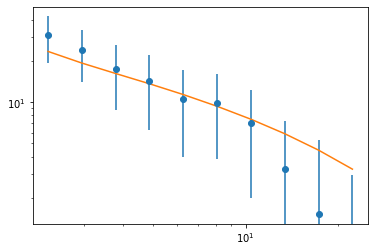

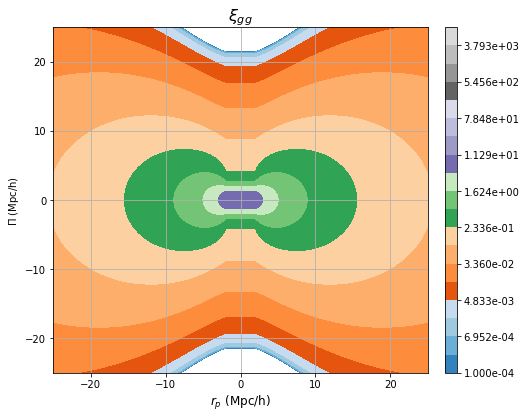

In [29]:
# wgg_sim = pd.read_csv('snr_data_new/wgg.csv', index_col=0)

wgg_fit = curve_fit(wgg, wgg_sim.rp, wgg_sim.wgg, sigma=wgg_sim.wgg_err)
# wgg_fit = curve_fit(wgg, wgg_sim.rp, wgg_sim.wgg, sigma=wgg_cov)

plt.errorbar(wgg_sim.rp, wgg_sim.wgg, wgg_sim.wgg_err, fmt='o')
plt.plot(wgg_sim.rp, wgg(wgg_sim.rp, wgg_fit[0][0]))

plt.loglog()

# Fitted galaxy bias
bias = wgg_fit[0][0]

xigg = (bias**2) * pcr.xi_rp_pi(f, bg1=bias, pk=pk, l=[0,2,4], rp=rp, pi=pi)

levels = np.logspace(-4, 4, 20)
plot_corr(rp, pi, xigg, levels, 'gg')

bias

# Refitting for $b_g$ with $\xi_{gg}^{0}(r,\mu)$

In [30]:
gg_mono = read_output(file_dir_auto, var=['wgg'], coords=7, rsd=global_rsd)['data'][['rp', 'wgg', 'wgg_err']]

In [31]:
def cut_gg_monopole(r, new_bias, thresh=0):
    mu = np.linspace(-1, 1, 200)
    dmu = np.gradient(mu)
    
    rG, muG = np.meshgrid(r, mu)
    
    rpG = np.sqrt(1-muG**2) * rG
    
    alpha = pcr.alpha(0, f/new_bias, f/new_bias, spin=0)
    prefactor = float(alpha) * (new_bias**2)
    
    r_i, xi_i = pcr.get_xi_multipole(pk=pk, l=[0])
    xi_i_interp = np.interp(rG, r_i[0], prefactor * xi_i[0], left=0, right=0)
    
    xi = xi_i_interp * 1 # Monopole legendre polynomial is just 1 
    cut_xi = cut_data(rG, muG, xi, thresh=thresh)
    
    mono = (dmu @ (cut_xi))
    
    return mono

In [32]:
mono_fit = lambda r, new_bias : cut_gg_monopole(r, new_bias, thresh=global_rp_cut)

monopole_fit = curve_fit(mono_fit, gg_mono['rp'], gg_mono['wgg'], sigma=gg_mono['wgg_err'])

monopole_fit

(array([1.05557659]), array([[0.00216228]]))

Text(0.5, 0, '$r$ (Mpc/h)')

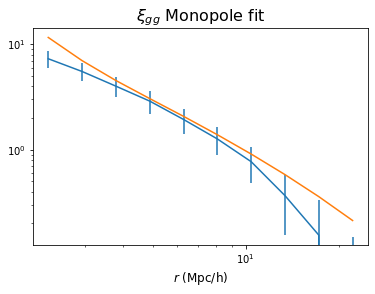

In [33]:
plt.errorbar(gg_mono['rp'], gg_mono['wgg'], gg_mono['wgg_err'])
plt.plot(gg_mono['rp'], cut_gg_monopole(gg_mono['rp'], monopole_fit[0][0]))
plt.loglog()

plt.title('$\\xi_{gg}$ Monopole fit', fontsize=16)
plt.xlabel('$r$ (Mpc/h)', fontsize=12)

## $ \xi_{g+} $ and $ w_{g+} $ Calculations

In [34]:
rp = np.linspace(0, 25, 500)
pi = np.linspace(-25, 25, 1000)

In [35]:
def wgp(rp_interp, ai):
    
    xigp = ai * zeta * bias * pcr.xi_rp_pi(f, bg1=bias, pk=pk, l=[2,4], spin=2, rp=rp, pi=pi)
    dpi = np.gradient(pi)
    
    wgp_pts = dpi@xigp
    wgp_interp = interp1d(rp, wgp_pts)
    
    return wgp_interp(rp_interp)

array([[5.28124697]])

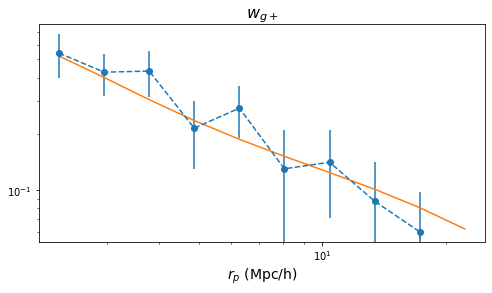

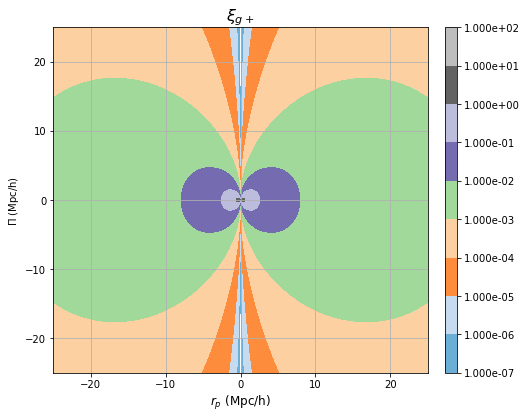

In [36]:
# wgp_sim = pd.read_csv('snr_data_new/wgp.csv', index_col=0)

# wgp_fit = curve_fit(wgp, wgp_sim.rp, wgp_sim.wgp, sigma=wgp_sim.wgp_err)
wgp_fit = curve_fit(wgp, wgp_sim.rp, wgp_sim.wgp, sigma=wgp_sim.wgp_err)


# Fitted alignment parameter
ai = wgp_fit[0][0]
# print(ai)

d = np.array([wgp(wgp_sim.rp, ai)])
before = np.sqrt(d@np.linalg.inv(wgp_cov)@d.T)

xigp = np.array(ai * zeta * bias * pcr.xi_rp_pi(f, bg1=bias, pk=pk, l=[2,4], spin=2, rp=rp, pi=pi))

levels = np.logspace(-7, 2, 10)

plt.figure(figsize=(8, 4))

plt.errorbar(wgp_sim.rp, wgp_sim.wgp, wgp_sim.wgp_err, fmt='o--')
plt.plot(wgp_sim.rp, d[0])
plt.loglog()

plt.title('$w_{g+}$', fontsize=16)
plt.xlabel('$r_p$ (Mpc/h)', fontsize=14)

plot_corr(rp, pi, xigp, levels, 'g+')

before

In [37]:
def chi_sq(theory_y, data_y):
    chi_square = np.sum(((theory_y - data_y)**2)/(theory_y))
    return chi_square

In [38]:
# f = cosmo.Om0**.55
betaD = f / bias

# The Finale

In [39]:
f/bias

0.615859750174146

In [40]:
def calc_quadrupole(rG, muG, xiG):
    dmu = np.gradient(muG, axis=0)
    aL = associated_legendre(2,2,muG)
#     return rG[0], (5/2)*np.sum(dmu*aL*xiG, axis=0)
    return rG[0], (5./48.)*np.sum(dmu*aL*xiG, axis=0)

In [41]:
def cut_gp_quadrupole(r, new_ai, thresh=0):
    mu = np.linspace(-1, 1, 500)
    dmu = np.gradient(mu)
    
    rG, muG = np.meshgrid(r, mu)
    
    rpG = np.sqrt(1-muG**2) * rG
    
    alpha = pcr.alpha(2, f/bias, f/bias, spin=2)
    prefactor = -1 * float(alpha) * zeta * new_ai * bias
    
    r_i, xi_i = pcr.get_xi_multipole(pk=pk, l=[2])
    xi_i_interp = np.interp(rG, r_i[2], prefactor * xi_i[2], left=0, right=0)
    
    xi = xi_i_interp * associated_legendre(2,2,muG)
    cut_xi = cut_data(rG, muG, xi, thresh=thresh)
    
    quad = (5./48.) * (dmu @ (cut_xi * associated_legendre(2,2,muG)))
    
    return quad

In [42]:
# Fits and plots quadrupole with specified lower rp bound, returns SNR and fitted A_I (with variance)

def fit_quadrupole(rp_lower=0, rsd=False):
    
    xigp_jk = read_output(file_dir_cross, var=['wgg', 'wgp'], bins2D=True, rsd=rsd, coords=7)
    xigp = pd.DataFrame(read_output(file_dir_cross, 
                                        var=['wgg', 'wgp'], 
                                        bins2D=True, rsd=rsd, 
                                        coords=7)['data'][['rp', 'pi', 'wgg', 'wgg_err', 'wgp', 'wgp_err']]
                           ).rename(columns={'rp':'r', 'pi':'mu'})
    
    shape2 = (len(xigp.r.unique()), len(xigp.mu.unique()))

    b = {}
    c = []
    
    def get_box_quad(xigp_jk, i):
        box = xigp_jk[i]
        box_rG = box['rp'].reshape(shape2).T
        box_muG = box['pi'].reshape(shape2).T
        box_xigpG = cut_data(box_rG, box_muG, box['wgp'].reshape(shape2).T, thresh=rp_lower)
        
        return calc_quadrupole(box_rG, box_muG, box_xigpG)

    for i in np.arange(njk):
        box_r, box_quad = get_box_quad(xigp_jk, i)
        b[i] = box_quad
        
    cc = cov_corr()
    b['cov'], b['corr'] = cc.dict_cov(dic=b,stack=1)
    b['cov']*= (njk-1)
    
    fit_fn = lambda r, new_ai : cut_gp_quadrupole(r, new_ai, thresh=rp_lower)
        
    for i in np.arange(njk):
        box_r, box_quad = get_box_quad(xigp_jk, i)
        c.append(curve_fit(fit_fn, box_r, box_quad, sigma=np.sqrt(np.diag(b['cov'])))[0][0])
    
    # print(c)
    ai_var = np.var(c)
    ai_var *= (njk-1)

    rG = xigp.r.to_numpy().reshape(shape2).T
    muG = xigp.mu.to_numpy().reshape(shape2).T
    xigpG = xigp.wgp.to_numpy().reshape(shape2).T

    rq, q = calc_quadrupole(rG, muG, cut_data(rG, muG, xigpG, thresh=rp_lower))

    quad_ai, pcov = curve_fit(fit_fn, rq, q, sigma=np.sqrt(np.diag(b['cov'])), absolute_sigma=True)
    print(b['cov'])
    # quad_ai, pcov = curve_fit(fit_fn, rq, q, sigma=b['cov'])
    
    # print(quad_ai)

    qt = np.array([cut_gp_quadrupole(rq, quad_ai, thresh=rp_lower)])
    
    rt = np.linspace(1, 25, 250)
    qft = np.array([cut_gp_quadrupole(rt, quad_ai, thresh=rp_lower)])
    
    chi_sq = np.sum(((q-qt)/(np.sqrt(np.diag(b['cov']))))**2)
    print(chi_sq)

    plt.figure(figsize=(6, 4))
    plt.errorbar(rq, q, np.sqrt(np.diag(b['cov'])), fmt='o--')
    plt.plot(rt, qft[0])
    plt.loglog()
    plt.grid()

    plt.title('$\\xi_{g+}^{4}(r)$', fontsize=16)
    plt.xlabel('$r$ (Mpc/h)', fontsize=14)

    return (quad_ai, ai_var), np.sqrt(qt @ np.linalg.inv(b['cov']) @ qt.T)

[[ 2.96271892e-05  1.38069670e-05  8.40710283e-06  3.80416718e-06
   4.14793699e-06  2.47070275e-06 -1.83371786e-07  1.39218011e-07
   4.09229487e-09 -1.58992050e-07]
 [ 1.38069670e-05  1.45426361e-05  8.27290376e-06  5.32465538e-06
   3.49960394e-06  1.43846887e-06  1.07495799e-07  2.46884769e-07
   2.80522208e-07  1.72601077e-07]
 [ 8.40710283e-06  8.27290376e-06  7.45674273e-06  3.87367243e-06
   3.10854159e-06  1.46020898e-06  6.29356050e-07  4.19177421e-07
   2.18472088e-07  2.66673202e-07]
 [ 3.80416718e-06  5.32465538e-06  3.87367243e-06  3.95686331e-06
   2.44265529e-06  1.39253056e-06  6.81693494e-07  4.65081678e-07
   2.78364263e-07  1.51564532e-07]
 [ 4.14793699e-06  3.49960394e-06  3.10854159e-06  2.44265529e-06
   3.07758507e-06  1.77593122e-06  1.03636522e-06  6.12859663e-07
   3.59672455e-07  2.43197787e-07]
 [ 2.47070275e-06  1.43846887e-06  1.46020898e-06  1.39253056e-06
   1.77593122e-06  1.67267042e-06  1.08277824e-06  6.09580867e-07
   2.56051777e-07  9.45861884e-08

((array([3.53598355]), 0.39797756201410284), array([[7.96737574]]))

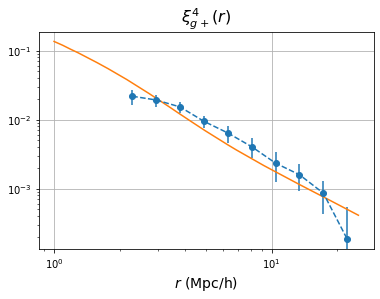

In [43]:
fit_quadrupole(rp_lower=0, rsd=global_rsd)

[[ 2.82426072e-05  1.22654147e-05  7.74834314e-06  3.41711340e-06
   3.84754655e-06  2.38187148e-06 -1.73362590e-07  1.28152990e-07
  -2.75115280e-08 -1.97884576e-07]
 [ 1.22654147e-05  1.32463775e-05  7.81164124e-06  5.08816553e-06
   3.27300121e-06  1.35948124e-06  1.04813650e-07  2.34006221e-07
   2.60559972e-07  1.48158764e-07]
 [ 7.74834314e-06  7.81164124e-06  7.45674273e-06  3.87367243e-06
   3.10854159e-06  1.46020898e-06  6.29356050e-07  4.19177421e-07
   2.18472088e-07  2.66673202e-07]
 [ 3.41711340e-06  5.08816553e-06  3.87367243e-06  3.95686331e-06
   2.44265529e-06  1.39253056e-06  6.81693494e-07  4.65081678e-07
   2.78364263e-07  1.51564532e-07]
 [ 3.84754655e-06  3.27300121e-06  3.10854159e-06  2.44265529e-06
   3.07758507e-06  1.77593122e-06  1.03636522e-06  6.12859663e-07
   3.59672455e-07  2.43197787e-07]
 [ 2.38187148e-06  1.35948124e-06  1.46020898e-06  1.39253056e-06
   1.77593122e-06  1.67267042e-06  1.08277824e-06  6.09580867e-07
   2.56051777e-07  9.45861884e-08

((array([3.41814994]), 0.374263278236332), array([[7.94204678]]))

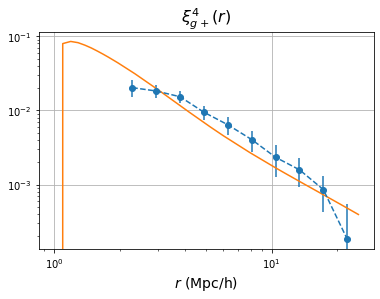

In [44]:
fit_quadrupole(rp_lower=1, rsd=global_rsd)

[[3.76319396e-06 3.77597960e-06 2.26729211e-06 1.63671784e-06
  1.43076203e-06 7.61687884e-07 1.11334947e-07 1.92187185e-07
  1.82133678e-07 6.43559637e-08]
 [3.77597960e-06 9.07003924e-06 5.83682814e-06 4.20548180e-06
  2.61155460e-06 1.21196442e-06 3.64956214e-07 3.43270474e-07
  2.64172447e-07 1.21635662e-07]
 [2.26729211e-06 5.83682814e-06 6.45305283e-06 3.49624385e-06
  2.77452269e-06 1.40724715e-06 6.87482333e-07 4.36282541e-07
  2.04245612e-07 2.41260022e-07]
 [1.63671784e-06 4.20548180e-06 3.49624385e-06 3.83837559e-06
  2.34195764e-06 1.36878921e-06 6.89427395e-07 4.64565358e-07
  2.74976876e-07 1.46628082e-07]
 [1.43076203e-06 2.61155460e-06 2.77452269e-06 2.34195764e-06
  2.99220749e-06 1.76374225e-06 1.04346562e-06 6.13729602e-07
  3.57858583e-07 2.38934533e-07]
 [7.61687884e-07 1.21196442e-06 1.40724715e-06 1.36878921e-06
  1.76374225e-06 1.67267042e-06 1.08277824e-06 6.09580867e-07
  2.56051777e-07 9.45861884e-08]
 [1.11334947e-07 3.64956214e-07 6.87482333e-07 6.89427395e

((array([3.46756572]), 0.38280773271459967), array([[7.12451045]]))

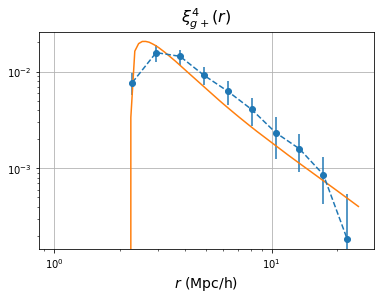

In [45]:
fit_quadrupole(rp_lower=2.25, rsd=global_rsd)